# Assignment: k-NN, regression) trong bài toán dự đoán giá bất động sản

Tổng quan: Ở bài tập này chúng ta áp dụng một số phương pháp hồi quy tuyến tính, hồi quy k-NN cho dự đoán giá bất động sản Montreal, Houston

## Câu hỏi 1: khảo sát tập dữ liệu đơn gian Iris data set
xem có bao nhiêu bản ghi, bao nhiêu thuộc tính, xem một mẫu đầu tiên, bỏ những cột dư thừa, ...

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np

In [2]:
iris=pd.read_csv('data/iris.csv')

In [3]:
iris.columns

Index(['Unnamed: 0', 'Sepal.Length', 'Sepal.Width', 'Petal.Length',
       'Petal.Width', 'Species'],
      dtype='object')

In [4]:
#### YOUR CODE HERE ####


#Show the number of observations
print("The number of observations: ", len(iris))


#delete the redundant column
iris = iris.loc[:, ~iris.columns.str.contains('^Unnamed')]

#Show the number of properties
print("The number of properties: ",len(iris.columns))

#Show the first sample
iris.head(1)

#### END YOUR CODE #####


The number of observations:  150
The number of properties:  5


,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa


## Câu hỏi 2: dự đoán giá bất động sản tỉnh Montreal

Mục tiêu đưa ra dự báo giá nhà dựa trên các thông tin thông tin quan trọng về nhà, dựa vào các mô hình hồi quy tuyến tính, hồi quy tuyến tính Ridge, hồi quy Laso, và hồi quy k lân cận gần nhất. Đánh giá trung bình sai số tuyệt đối của các mô hình trên dữ liệu kiểm tra.

## Dữ liệu

In [5]:
import pandas as pd
data=pd.read_csv("data/final_dataDec.csv")

In [6]:
data.head()

,not_sold,2014,2013,2012,2011,2010,2009,2008,2007,2006,...,emergency_shelters,emergency_water,Facilities,fire_stations,Cultural,Monuments,police_stations,Vacant,Free_Parking,askprice
0,1,0,0,0,0,0,0,0,0,0,...,37,274,210,43,71,43,25,43,52,166000
1,1,0,0,0,0,0,0,0,0,0,...,19,120,1,15,24,5,7,0,4,349000
2,1,0,0,0,0,0,0,0,0,0,...,27,191,155,28,54,32,18,19,43,224900
3,1,0,0,0,0,0,0,0,0,0,...,10,82,0,13,10,2,5,0,1,585000
4,1,0,0,0,0,0,0,0,0,0,...,30,238,216,37,66,42,20,43,52,312900


In [7]:
features=data.columns.values
features

array(['not_sold', '2014', '2013', '2012', '2011', '2010', '2009', '2008',
       '2007', '2006', '2005', '2004', '2003', '2002', 'num_bed',
       'year_built', 'longitude', 'latitude', 'num_room', 'num_bath',
       'living_area', 'house', 'plex', 'chalet', 'loft', 'condo',
       'num_parking', 'accessible_buildings', 'family_quality',
       'art_expos', 'emergency_shelters', 'emergency_water', 'Facilities',
       'fire_stations', 'Cultural', 'Monuments', 'police_stations',
       'Vacant', 'Free_Parking', 'askprice'], dtype=object)

In [8]:
data.shape

(9717, 40)

## Xử lý dữ liệu với các giá trị missing
- Loại bỏ các bản ghi có giá trị missing
- Khôi phục giá trị mising bằng giá trị trung bình

In [9]:
len(features)

40

In [10]:
features[0] # Thuộc tính not_sold, 1 chưa bán, 0 đã bán

'not_sold'

In [11]:
features[1:14]# Các thuộc tính bán năm 2002-> 2014: 1 năm bán

array(['2014', '2013', '2012', '2011', '2010', '2009', '2008', '2007',
       '2006', '2005', '2004', '2003', '2002'], dtype=object)

In [12]:
features[14:16]# Số giường, năm xây dựng

array(['num_bed', 'year_built'], dtype=object)

In [13]:
features[16:18]# Tọa độ

array(['longitude', 'latitude'], dtype=object)

In [14]:
features[18:21]# Số phòng, số phòng tắm, diện tích

array(['num_room', 'num_bath', 'living_area'], dtype=object)

In [15]:
features[21:26]# Tính chất bất động sản

array(['house', 'plex', 'chalet', 'loft', 'condo'], dtype=object)

In [16]:
features[26:30]

array(['num_parking', 'accessible_buildings', 'family_quality',
       'art_expos'], dtype=object)

In [17]:
features[30:35]

array(['emergency_shelters', 'emergency_water', 'Facilities',
       'fire_stations', 'Cultural'], dtype=object)

In [18]:
features[35:39]

array(['Monuments', 'police_stations', 'Vacant', 'Free_Parking'],
      dtype=object)

In [19]:
features[39] # Giá tài sản

'askprice'

Các biến phụ thuộc **39**, biến dự báo **1** 

In [20]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
#from sklearn.select_model import cross_validation
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import normalize

In [21]:
def loadData(filename):
	data = np.genfromtxt(filename, delimiter=',', dtype=float, skip_header=1)
	return data

In [22]:
data=loadData("data/final_dataDec.csv")

In [23]:
def remove_missing_data(pX_train, feature_to_impute):
    X_train =  np.copy(pX_train)
    for i in range(X_train.shape[0]-1, 0, -1):
        for j in range(0, X_train.shape[1], 1):
            if feature_to_impute[j] != 0 and X_train[i, j] == 0:
                X_train = np.delete(X_train, i, 0)
                break
    return X_train

In [24]:
impute = np.array([0] * len(data[0]))
impute[14] = 2 # num_bed
impute[15] = 2 # year_built
impute[18] = 2 # num_room
impute[19] = 2 # num_bath
impute[20] = 1 # living_space

In [25]:
data_removal=remove_missing_data(data,impute)

In [26]:
data_removal.shape

(2289, 40)

In [27]:
def mean_imputation_pure(pX_train, feature_to_impute):
	X_train =  np.copy(pX_train)
	for i in range(0, len(feature_to_impute)):
		if feature_to_impute[i] == 0:
			continue
		non_zeros = 0
		for j in range(0, X_train.shape[0]):
			if X_train[j, i] != 0:
				non_zeros += 1
		mean = np.sum(X_train[:, i])/float(non_zeros)
		for j in range(0, X_train.shape[0]):
			if X_train[j, i] == 0:
				X_train[j, i] = mean
	return X_train

In [67]:
data_imputation=mean_imputation_pure(data,impute)

In [63]:
data_imputation.shape

(9717, 40)

### Dự báo giá nhà với dữ liệu data_removal (bỏ các bản ghi lỗi)
- Dữ liệu data_removal
- Chia dữ liệu thành dữ liệu huấn luyện (70%) và dữ liệu kiểm tra (30%)

In [58]:
xrm=data_removal[:,:39]## Biến độc lập
yrm=data_removal[:,39] # Biến phụ thuộc

In [59]:
from sklearn.model_selection import train_test_split
xrm_train, xrm_test, yrm_train, yrm_test = train_test_split(xrm, yrm,test_size = 0.3, random_state=42)

** Hồi quy tuyến tính Ridge**

Tính trung bình sai số tuyệt đối trên dữ liệu kiểm tra, tìm lambda tốt nhất, vẽ biểu diến sai số theo lambda

Sai số tuyệt đối trung bình của dữ liệu test =  45597.864554724794


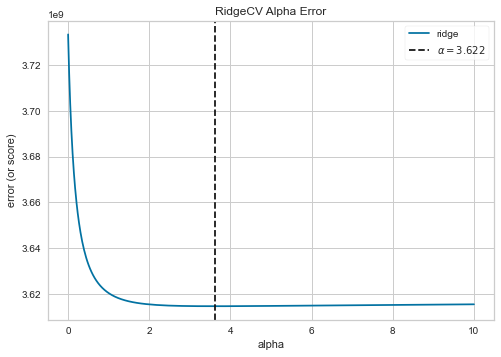

In [57]:
#### YOUR CODE HERE ####
ridge = Ridge(alpha=0.1, normalize=True)
ridge.fit(xrm_train, yrm_train)

Y_predict = ridge.predict(xrm_train)
Y_predict_test = ridge.predict(xrm_test)

print("Sai số tuyệt đối trung bình của dữ liệu test = ", mean_absolute_error(yrm_test,Y_predict_test))
ridge_pred = ridge.predict(xrm_test)
# print("R^2 test = ", ridge.score(xrm_test, yrm_test))

from sklearn.linear_model import RidgeCV
from yellowbrick.regressor import AlphaSelection
alphas = np.logspace(-10, 1, 400)
model = RidgeCV(alphas=alphas)
visualizer = AlphaSelection(model)
yrm_train=yrm_train.ravel()
visualizer.fit(xrm_train, yrm_train)
visualizer.poof()
#### END YOUR CODE #####

** Hồi quy tuyến tính Lasso**

Tính trung bình sai số tuyệt đối trên dữ liệu kiểm tra, tìm lambda tốt nhất, vẽ biểu diến sai số theo lambda

Sai số tuyệt đối trung bình của dữ liệu kiểm tra =  44836.03006284669


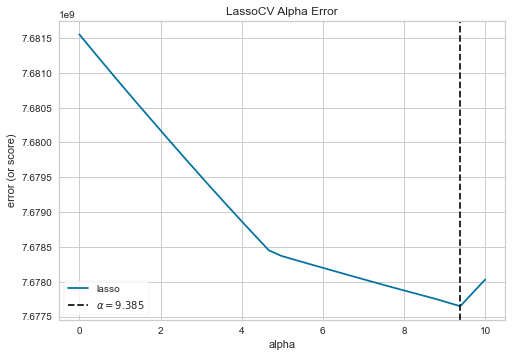

In [60]:
xrm=data_removal[:,:39]## Biến độc lập
yrm=data_removal[:,39] # Biến phụ thuộc
xrm_train, xrm_test, yrm_train, yrm_test = train_test_split(xrm, yrm,test_size = 0.3, random_state=42)
lasso = Lasso(alpha=0.1, normalize=True)
lasso.fit(xrm_train, yrm_train)
lasso_pred = lasso.predict(xrm_test)
# lasso.score(x_imputation_test, y_imputation_test)

yrm_predict = lasso.predict(xrm_test)
print("Sai số tuyệt đối trung bình của dữ liệu kiểm tra = ", mean_absolute_error(yrm_test,yrm_predict))

import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV
from yellowbrick.regressor import AlphaSelection
alphas = np.logspace(-10,1,400)
model = LassoCV(alphas=alphas)
visualizer = AlphaSelection(model)
y_imputation_train=y_imputation_train.ravel()
            
visualizer.fit(x_imputation_train, y_imputation_train)
g = visualizer.poof()

### Dự báo giá nhà với dữ liệu imputation (làm đầy các bản ghi bị lỗi)
- Dữ liệu data_imputation
- Chia dữ liệu thành dữ liệu huấn luyện (70%) và dữ liệu kiểm tra (30%)
- Thực hiện các câu hỏi như trên

** Hồi quy tuyến tính **

Sai số tuyệt đối trung bình của dữ liệu kiểm tra =  1053840001643.083


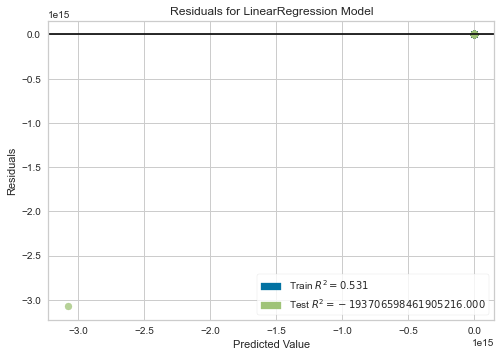

In [68]:
#### YOUR CODE HERE ####
x_imputation = data_imputation[:,:39]## Biến độc lập
y_imputation = data_imputation[:,39] # Biến phụ thuộc
from sklearn.model_selection import train_test_split
x_imputation_train, x_imputation_test, y_imputation_train, y_imputation_test = train_test_split(x_imputation, y_imputation,test_size = 0.3, random_state=42)
reg = LinearRegression()
reg.fit(x_imputation_train, y_imputation_train)

Y_imputation_predict = reg.predict(x_imputation_test)
print("Sai số tuyệt đối trung bình của dữ liệu kiểm tra = ", mean_absolute_error(y_imputation_test,Y_imputation_predict))

# y_pred=reg.predict(x_imputation_test)
# Hệ số R^2
# print(reg.score(x_imputation_train, y_imputation_train))
from yellowbrick.regressor import ResidualsPlot
viz = ResidualsPlot(reg, hist=False)
viz.fit(x_imputation_train, y_imputation_train)  # Fit the training data to the model
viz.score(x_imputation_test, y_imputation_test)  # Evaluate the model on the test data
viz.poof()   
#### END YOUR CODE #####

** Hồi quy tuyến tính Ridge**

Sai số tuyệt đối trung bình của dữ liệu kiểm tra =  68930.47951044414


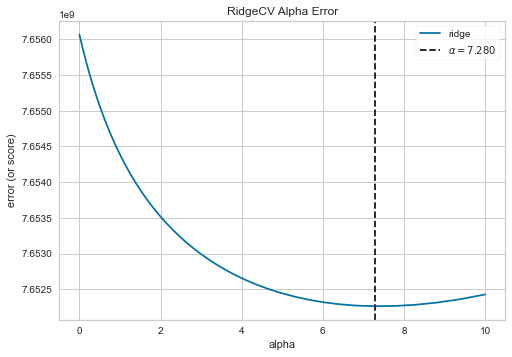

In [64]:
#### YOUR CODE HERE ####
#### YOUR CODE HERE ####
x_imputation = data_imputation[:,:39]## Biến độc lập
y_imputation = data_imputation[:,39] # Biến phụ thuộc
x_imputation_train, x_imputation_test, y_imputation_train, y_imputation_test = train_test_split(x_imputation, y_imputation,test_size = 0.3, random_state=42)
ridge = Ridge(alpha=0.1, normalize=True)
ridge.fit(x_imputation_train, y_imputation_train)
# print("R^2 train = ", ridge.score(x_imputation_train,y_imputation_train))

Y_imputation_predict = ridge.predict(x_imputation_test)
print("Sai số tuyệt đối trung bình của dữ liệu kiểm tra = ", mean_absolute_error(y_imputation_test,Y_imputation_predict))



# ridge_pred = ridge.predict(x_imputation_test)
# print("R^2 test = ", ridge.score(x_imputation_test, y_imputation_test))

from sklearn.linear_model import RidgeCV
from yellowbrick.regressor import AlphaSelection
alphas = np.logspace(-10, 1, 400)
model = RidgeCV(alphas=alphas)
visualizer = AlphaSelection(model)
y_imputation_train=y_imputation_train.ravel()
visualizer.fit(x_imputation_train, y_imputation_train)
visualizer.poof()
#### END YOUR CODE #####
#### END YOUR CODE #####

** Hồi quy tuyến tính Lasso**

Sai số tuyệt đối trung bình của dữ liệu kiểm tra =  67293.34983138043


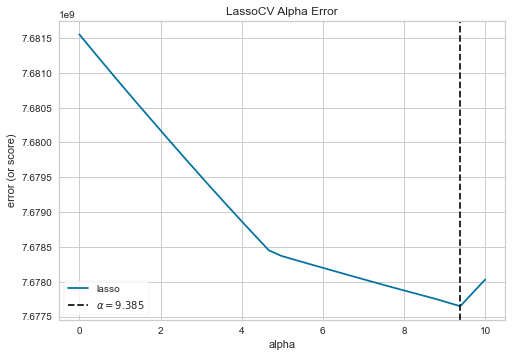

In [65]:
#### YOUR CODE HERE ####
#### YOUR CODE HERE ####
#### YOUR CODE HERE ####
x_imputation = data_imputation[:,:39]## Biến độc lập
y_imputation = data_imputation[:,39] # Biến phụ thuộc
x_imputation_train, x_imputation_test, y_imputation_train, y_imputation_test = train_test_split(x_imputation, y_imputation,test_size = 0.3, random_state=42)
lasso = Lasso(alpha=0.1, normalize=True)
lasso.fit(x_imputation_train, y_imputation_train)
lasso_pred = lasso.predict(x_imputation_test)
lasso.score(x_imputation_test, y_imputation_test)

Y_imputation_predict = lasso.predict(x_imputation_test)
print("Sai số tuyệt đối trung bình của dữ liệu kiểm tra = ", mean_absolute_error(y_imputation_test,Y_imputation_predict))

import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV
from yellowbrick.regressor import AlphaSelection
alphas = np.logspace(-10,1,400)
model = LassoCV(alphas=alphas)
visualizer = AlphaSelection(model)
y_imputation_train=y_imputation_train.ravel()
            
visualizer.fit(x_imputation_train, y_imputation_train)
g = visualizer.poof()

#### END YOUR CODE #####
#### END YOUR CODE #####
#### END YOUR CODE #####

**Hồi quy phi tuyến K lân cận gần nhất**

Sai số tuyệt đối trung bình của dữ liệu kiểm tra = 76402.0237722908


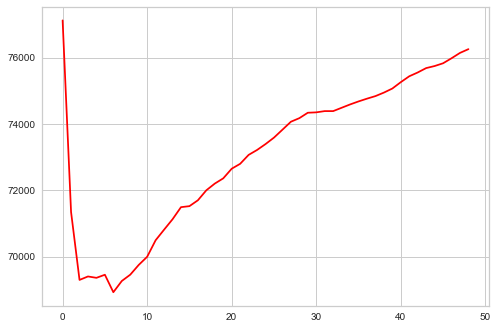

Optimal k:  7


In [53]:
#### YOUR CODE HERE ####
x_imputation = data_imputation[:,:39]## Biến độc lập
y_imputation = data_imputation[:,39] # Biến phụ thuộc
x_imputation_train, x_imputation_test, y_imputation_train, y_imputation_test = train_test_split(x_imputation, y_imputation,test_size = 0.3, random_state=42)

knnreg_imputation = KNeighborsRegressor(n_neighbors=50)
knnreg_imputation.fit(x_imputation_train, y_imputation_train)


# knnreg_imputation.score(x_imputation_train, y_imputation_train)
print("Sai số tuyệt đối trung bình của dữ liệu kiểm tra =", mean_absolute_error(y_imputation_test,knnreg_imputation.predict(x_imputation_test)))
mae=[]
for k in range(1,50):
    reg=KNeighborsRegressor(n_neighbors=k)
    reg.fit(x_imputation_train,y_imputation_train)
    error=mean_absolute_error(y_imputation_test,reg.predict(x_imputation_test))
    mae.append(error)
    
import matplotlib.pyplot as plt
plt.plot(mae,c='red')
plt.show()
print("Optimal k: ", np.argmin(mae)+1)

#### END YOUR CODE #####